<a href="https://colab.research.google.com/github/nahbos/AUT-Language-Understanding/blob/main/Ex01/G2P_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/train_data.txt
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/test_data.txt

File ‘train_data.txt’ already there; not retrieving.

File ‘test_data.txt’ already there; not retrieving.



In [73]:
# Replicated by @SobhanMoradianDaghigh on 11-5-2022


# Import Libraries -------------------------
import os
import time
import argparse
import random
import math


import Levenshtein  # for PER I prefer to use Levenshtein rather to jiwer: https://github.com/ztane/python-Levenshtein/


# Torch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data


# Checking if the CUDA is available on the Local system: Sobhans' GTX1050 > returned True
# print(torch.cuda.is_available())


# Setting the args
parser = {
    'data_path': './',

    'epochs': 50,
    'batch_size': 256,

    'max_len': 40,  # max length of grapheme/phoneme sequences

    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 1e-5,  # stop when lr is too low
    'n_bad_loss': 3,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient

    'log_every': 200,  # number of iterations to log and validate training
    
    'cuda': True,  # using gpu or not
    'seed': 5,  # initial seed
    'intermediate_path': './',  # path to save models
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()
if not os.path.isdir(args.intermediate_path):
    os.makedirs(args.intermediate_path)

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)


config = args
config.best_model = os.path.join(config.intermediate_path, "best_model_adagrad_attn.pth")
device = torch.device('cuda') if args.cuda else torch.device('cpu')


def phoneme_error_rate(p_seq1, p_seq2):
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return Levenshtein.distance(''.join(c_seq1), ''.join(c_seq2)) / len(c_seq2)

In [74]:
graphemes = ['PAD', 'SOS'] + ['EOS']
phonemes  = ['PAD', 'SOS'] + ['EOS']

with open('./train_data.txt', 'r') as f:
    data = f.read().strip().split('\n')
    for ele in data:
        temp = ele.split('\t')
        for g in list(temp[0]):
            graphemes.insert(-1, g)

        for p in list(temp[1]):
            phonemes.insert(-1, p)

graphemes = sorted(set(graphemes), key=graphemes.index)
phonemes  = sorted(set(phonemes),  key=phonemes.index)

g2idx = {g: idx for idx, g in enumerate(graphemes)}
idx2g = {idx: g for idx, g in enumerate(graphemes)}

p2idx = {p: idx for idx, p in enumerate(phonemes)}
idx2p = {idx: p for idx, p in enumerate(phonemes)}

def g2seq(s):
    return [g2idx['SOS']] + [g2idx[i] for i in s if i in g2idx.keys()] + [g2idx['EOS']]
    
def seq2g(s):
    return [idx2g[i] for i in s if idx2g[i]]

def p2seq(s):
    return [p2idx['SOS']] + [p2idx[i] for i in s if i in p2idx.keys()] + [p2idx['EOS']]

def seq2p(s):
    return [idx2p[i] for i in s]

In [75]:
len(graphemes), len(phonemes)

(44, 32)

In [76]:
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, path):
        self.x, self.y = [], []
        with open(path, 'r') as f:
            data = f.read().strip().split('\n')
        for line in data:
            x, y = line.split(maxsplit=1)
            self.x.append(g2seq(x))
            self.y.append(p2seq(y))

    def __getitem__(self, index):
        return (torch.LongTensor(self.x[index]), torch.LongTensor(self.y[index]))

    def __len__(self):
        return len(self.x)


class TextCollate():
    def __call__(self, batch):
        max_x_len = max([i[0].size(0) for i in batch])
        x_padded = torch.LongTensor(max_x_len, len(batch))
        x_padded.zero_()

        max_y_len = max([i[1].size(0) for i in batch])
        y_padded = torch.LongTensor(max_y_len, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x = batch[i][0]
            x_padded[:x.size(0), i] = x
            y = batch[i][1]
            y_padded[:y.size(0), i] = y

        return x_padded, y_padded

In [77]:
pin_memory = True
num_workers = 2

train_data = TextLoader(path='./train_data.txt')
testset = TextLoader(path='./test_data.txt')


def splits(trainset):

    train = []
    for ele in trainset:
        train.append(ele)

    random.shuffle(train)

    trainset, valset = [], []

    for i, line in enumerate(train):
        if i % 60 < 1:  # Try to separate about 1084 val from 65000
            valset.append(line)
        else:
            trainset.append(line)

    print((len(trainset), len(valset)))
    # Returned: (63916, 1084)

    return trainset, valset

trainset, valset = splits(train_data)

collate_fn = TextCollate()

train_loader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, shuffle=True, batch_size=args.batch_size, pin_memory=pin_memory, drop_last=True, collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(valset, num_workers=2, shuffle=False, batch_size=1, pin_memory=False, drop_last=False, collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(testset, num_workers=num_workers, shuffle=False, batch_size=1, pin_memory=pin_memory, drop_last=False, collate_fn=collate_fn)

(63916, 1084)


In [78]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, intoken, outtoken, hidden, enc_layers=3, dec_layers=1, dropout=0.1):
        super(TransformerModel, self).__init__()
        nhead = hidden//64
        
        self.encoder = nn.Embedding(intoken, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)

        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)

        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers, num_decoder_layers=dec_layers, dim_feedforward=hidden*4, dropout=dropout, activation='relu')
        self.fc_out = nn.Linear(hidden, outtoken)

        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def forward(self, src, trg):
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)

        src_pad_mask = self.make_len_mask(src)
        trg_pad_mask = self.make_len_mask(trg)

        src = self.encoder(src)
        src = self.pos_encoder(src)

        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask, memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask, memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

In [79]:
INPUT_DIM = len(graphemes)
OUTPUT_DIM = len(phonemes)

model = TransformerModel(INPUT_DIM, OUTPUT_DIM, hidden=128, enc_layers=3, dec_layers=1).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
print(model)

The model has 873,762 trainable parameters
TransformerModel(
  (encoder): Embedding(44, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Embedding(32, 128)
  (pos_decoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout

In [80]:
optimizer = optim.AdamW(model.parameters())
TRG_PAD_IDX = p2idx['PAD']
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [81]:
def train(model, optimizer, criterion, iterator, val_iter, epoch):
    
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop, train_loss_history, val_loss_history


    print("=> EPOCH {}".format(epoch))

    for batch in iterator:

        model.train()

        src, trg = batch
        src, trg = src.cuda(), trg.cuda()
        
        optimizer.zero_grad()
        output = model(src, trg[:-1,:])
        loss = criterion(output.transpose(0, 1).transpose(1, 2), trg[1:,:].transpose(0, 1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.data.item()
        train_loss_history.append(train_loss)


        if iteration % config.log_every == 0:
            val_loss = evaluate(model, criterion, val_iter)
            val_loss_history.append(val_loss)

            print("   % Time: {:5.0f} | Iteration: {:5} | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time() - init, iteration, train_loss, val_loss))

            
            # test for val_loss improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), config.best_model)
            else:
                n_bad_loss += 1
                
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

        train_loss = 0
        iteration += 1

In [82]:
def adjust_learning_rate(optimizer, lr_decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay


def evaluate(model, criterion, iterator):

    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.cuda(), trg.cuda()

            output = model(src, trg[:-1,:])
            loss = criterion(output.transpose(0, 1).transpose(1, 2), trg[1:,:].transpose(0, 1))
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [83]:
from tqdm.notebook import tqdm

def test(model, dataloader, show=10):
    model.eval()
    error_w = 0
    error_p = 0
    random_tests = random.sample(range(0, len(dataloader)), 50)
    all_output = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader)):
            src, trg = batch
            src, trg = src.cuda(), trg.cuda()
            real_p = seq2p(trg.squeeze(1).tolist())
            real_g = seq2g(src.squeeze(1).tolist()[1:-1])

            memory = model.transformer.encoder(model.pos_encoder(model.encoder(src)))

            out_indexes = [p2idx['SOS'], ]

            for i in range(args.max_len):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)

                output = model.fc_out(model.transformer.decoder(model.pos_decoder(model.decoder(trg_tensor)), memory))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == p2idx['EOS']:
                    break

            out_p = seq2p(out_indexes)
            error_w += int(real_p != out_p)
            error_p += phoneme_error_rate(real_p, out_p)

            all_output.append([''.join(real_g), ''.join(real_p[1:-1]), ''.join(out_p[1:-1])])
            
            # if idx in random_tests:
            #     print('>', ''.join(real_g))
            #     print('=', ''.join(real_p[1:-1]))
            #     print('<', ''.join(out_p[1:-1]))
            #     print()
            
    test_per = error_p / len(dataloader) * 100
    test_wer = error_w / len(dataloader) * 100
    print("Phoneme error rate (PER): {:.2f}\nWord error rate (WER): {:.2f}"
          .format(test_per, test_wer))
    
    return all_output

In [84]:
train_loss_history, val_loss_history = [], []
best_val_loss = 10
iteration = n_total = train_loss = n_bad_loss = 0
init = time.time()
stop = False

for epoch in range(args.epochs):
    train(model, optimizer, criterion, train_loader, val_loader, epoch + 1)
    if stop:
        break

=> EPOCH 1
   % Time:     6 | Iteration:     0 | Train loss: 3.6109 | Val loss: 3.2093
   % Time:    17 | Iteration:   200 | Train loss: 0.5703 | Val loss: 0.3965
=> EPOCH 2
   % Time:    34 | Iteration:   400 | Train loss: 0.4772 | Val loss: 0.3122
=> EPOCH 3
   % Time:    45 | Iteration:   600 | Train loss: 0.4202 | Val loss: 0.2814
=> EPOCH 4
   % Time:    56 | Iteration:   800 | Train loss: 0.3559 | Val loss: 0.2606
=> EPOCH 5
   % Time:    68 | Iteration:  1000 | Train loss: 0.3238 | Val loss: 0.2658
   % Time:    79 | Iteration:  1200 | Train loss: 0.3333 | Val loss: 0.2462
=> EPOCH 6
   % Time:    90 | Iteration:  1400 | Train loss: 0.2980 | Val loss: 0.2388
=> EPOCH 7
   % Time:   102 | Iteration:  1600 | Train loss: 0.3031 | Val loss: 0.2373
=> EPOCH 8
   % Time:   113 | Iteration:  1800 | Train loss: 0.2890 | Val loss: 0.2351
=> EPOCH 9
   % Time:   124 | Iteration:  2000 | Train loss: 0.2966 | Val loss: 0.2271
   % Time:   136 | Iteration:  2200 | Train loss: 0.2971 | Val lo

In [85]:
all_output = test(model, test_loader, show=50)

  0%|          | 0/10164 [00:00<?, ?it/s]

Phoneme error rate (PER): 5.84
Word error rate (WER): 33.21


In [86]:
string = 'سلام نام من سبحان مرادیان دقیق است'
outputs = []

for ele in string.split(' '):
  src = torch.tensor(g2seq(ele)).unsqueeze(1).cuda()

  memory = model.transformer.encoder(model.pos_encoder(model.encoder(src)))

  out_indexes = [p2idx['SOS'], ]

  for i in range(args.max_len):
      trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)

      output = model.fc_out(model.transformer.decoder(model.pos_decoder(model.decoder(trg_tensor)), memory))
      out_token = output.argmax(2)[-1].item()
      out_indexes.append(out_token)
      if out_token == p2idx['EOS']:
          outputs.append(seq2p(out_indexes)[1:-1])
          break

' '.join([''.join(chars) for chars in outputs])

"salAm nAm man sobhAn morAdiyAn daqiq 'est"

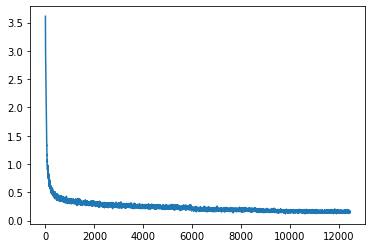

In [87]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history)

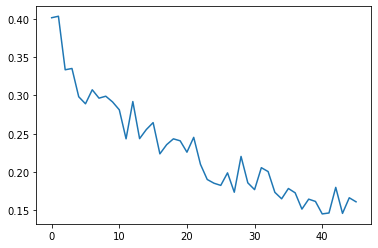

In [99]:
plt.plot(train_loss_history[500::260])

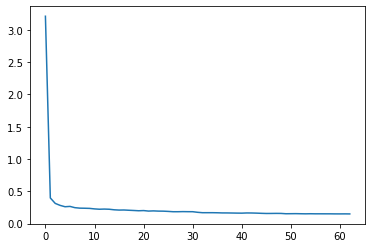

In [89]:
plt.plot(val_loss_history)

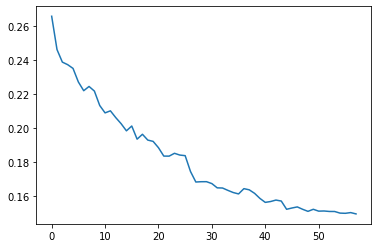

In [100]:
plt.plot(val_loss_history[5:])

In [109]:
words = ['بی‌خس', 'سورن']

for g, r_p, p_p in all_output:
  if g in words:
    print(g, r_p, p_p)

بی‌خس bixas bixas
سورن suran suran


Finito))